In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


from sklearn.mixture import GaussianMixture
from data_import_ashrae import DataImportAshrae
from aldi_evaluation_metrics import AldiEvaluationMetrics
from mergedeep import merge
from utils import (
    save_variable,
    load_variable,
    get_daily_resolution,
    forecasting_barplot,
    forecasting_bubble
)

import warnings
warnings.filterwarnings('ignore')


# BDG2

In [2]:
df_dataset=pd.read_excel('data/ashrae-energy-prediction/dataset_meta.xlsx', sheet_name='rawData', index_col=0)
df_dataset = df_dataset.rename(columns={'meter_reading':'Data points'})
df_dataset['site_id'] = 'Site' + df_dataset['site_id'].astype('str')
df_dataset

,site_id,building_id,primary_use,square_feet,year_built,floor_count,meter,Data points,meter_type,timezone
0,Site0,0,Education,7432,2008.0,NaN,0,8784,Electricity,US/Eastern
1,Site0,1,Education,2720,2004.0,NaN,0,8784,Electricity,US/Eastern
2,Site0,2,Education,5376,1991.0,NaN,0,8784,Electricity,US/Eastern
3,Site0,3,Education,23685,2002.0,NaN,0,8784,Electricity,US/Eastern
4,Site0,4,Education,116607,1975.0,NaN,0,8784,Electricity,US/Eastern
...,...,...,...,...,...,...,...,...,...,...
2375,Site15,1444,Entertainment/public assembly,19619,1914.0,NaN,0,7445,Electricity,US/Eastern
2376,Site15,1445,Education,4298,NaN,NaN,0,7449,Electricity,US/Eastern
2377,Site15,1446,Entertainment/public assembly,11265,1997.0,NaN,0,7472,Electricity,US/Eastern
2378,Site15,1447,Lodging/residential,29775,2001.0,NaN,0,7471,Electricity,US/Eastern


In [3]:
df_dataset['meter_type'] = df_dataset['meter_type'].replace({'Chilledwater':'Chilled water', 'Hotwater':'Hot water'})

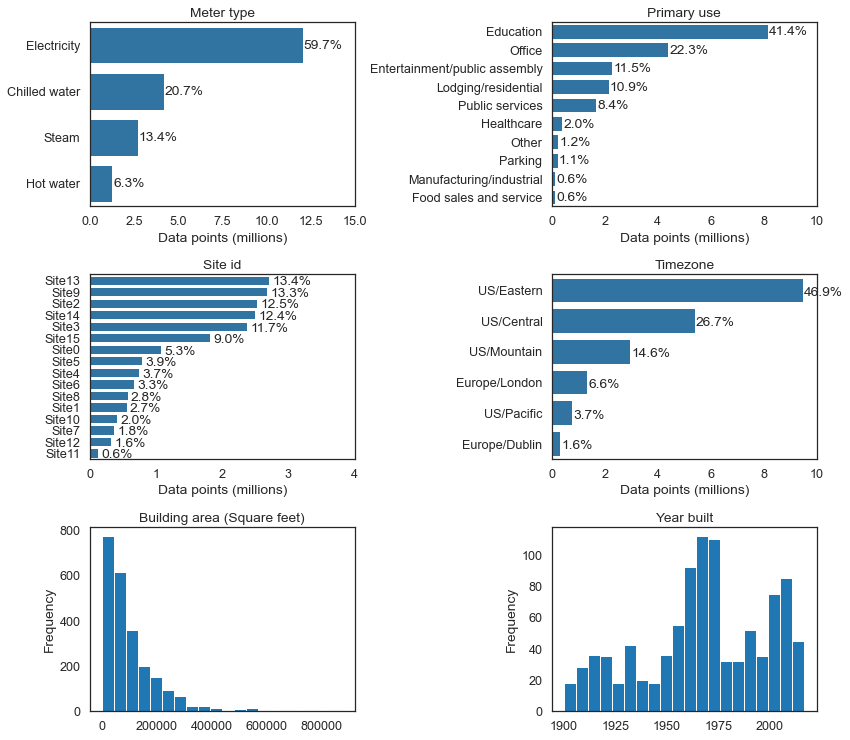

In [4]:
nr_rows = 3
nr_cols = 2

color = "#1f77b4"
sns.set(font_scale = 1.15)
sns.set_style(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*6,nr_rows*3.5))
        
#Fig 1: Data points of each meter type
# Temporary dataset
df_temp = df_dataset[['meter_type','Data points']].groupby('meter_type').sum().sort_values('Data points', ascending=False).reset_index()
df_temp.rename(columns={'meter_type':'meter type'}, inplace=True)
df_temp['Data points'] = df_temp['Data points']/10**6
# Plot
ax1 = sns.barplot(y="meter type", x="Data points", color= color, 
            data=df_temp,ax = axs[0][0])
ax1.title.set_text("Meter type")
ax1.set(ylabel="", xlabel="Data points (millions)", xlim=(0, 1.5*10))
# Adds percentage 
total = df_temp['Data points'].sum().sum()
for p in ax1.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.05
        y = p.get_y() + p.get_height()/1.7
        ax1.annotate(percentage, (x, y))
        
#Fig 2: Data points of each primary use
# Temporary dataset
df_temp = df_dataset[['primary_use','Data points']].groupby('primary_use').sum().sort_values('Data points', ascending=False).reset_index().iloc[:10,:]
df_temp.rename(columns={'primary_use':'primary use'}, inplace=True)
df_temp['Data points'] = df_temp['Data points']/10**6
# Plot
ax2 = sns.barplot(y="primary use", x="Data points", color= color, 
            data=df_temp,ax = axs[0][1])
ax2.title.set_text("Primary use")
ax2.set(ylabel="", xlabel="Data points (millions)", xlim=(0, 10))
# Adds percentage 
total = df_temp['Data points'].sum().sum()
for p in ax2.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.05
        y = p.get_y() + p.get_height()/1.35
        ax2.annotate(percentage, (x, y))
        
#Fig 3: Data points in each site
# Temporary dataset
df_temp = df_dataset[['site_id','Data points']].groupby('site_id').sum().sort_values('Data points', ascending=False).reset_index()
df_temp.rename(columns={'site_id':'site id'}, inplace=True)
df_temp['Data points'] = df_temp['Data points']/10**6
# Plot
ax3 = sns.barplot(y="site id", x="Data points", color= color, 
            data=df_temp,ax = axs[1][0])
ax3.title.set_text("Site id")
ax3.set(ylabel="", xlabel="Data points (millions)", xlim=(0, 4))
# Adds percentage 
total = df_temp['Data points'].sum().sum()
for p in ax3.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.05
        y = p.get_y() + p.get_height()/1
        ax3.annotate(percentage, (x, y))
        
#Fig 4: Data points in each timezone
# Temporary dataset
df_temp = df_dataset[['timezone','Data points']].groupby('timezone').sum().sort_values('Data points', ascending=False).reset_index()
df_temp.rename(columns={'timezone':'Timezone'}, inplace=True)
df_temp['Data points'] = df_temp['Data points']/10**6
# Plot
ax4 = sns.barplot(y="Timezone", x="Data points", color= color, 
            data=df_temp,ax = axs[1][1])
ax4.title.set_text("Timezone")
ax4.set(ylabel="", xlabel="Data points (millions)", xlim=(0, 10))
# Adds percentage 
total = df_temp['Data points'].sum().sum()
for p in ax4.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.05
        y = p.get_y() + p.get_height()/1.4
        ax4.annotate(percentage, (x, y))
        
#Fig 5: 
ax5 = sns.distplot(df_dataset['square_feet'], kde=False, bins=20, color= '#1f77b4', hist_kws=dict(alpha=1), ax = axs[2][0])
ax5.title.set_text("Building area (Square feet)")
ax5.set(ylabel="Frequency", xlabel="")

#Fig 6: 
ax6 = sns.distplot(df_dataset['year_built'], kde=False, bins=20, color= '#1f77b4', hist_kws=dict(alpha=1), ax = axs[2][1])
ax6.title.set_text("Year built")
ax6.set(ylabel="Frequency", xlabel="")
        
plt.tight_layout()    
fig.savefig("img/meta_summary.pdf", dpi=300)

# Benchmarking

In [2]:
algorithms = [
    'baseline',
    '2std',
    'aldi_vanilla',
    'discord_vae',
    'discords_aldi_gmm_weight_D-gmm_max_5', # ID07-05
]

dict_time = {
    'baseline': {'time': 480},
    '2std': {'time': 1}, # TODO run std model , # 1 minute
    'aldi_vanilla': {'time': 40},
    'discords_aldi_gmm_weight_D-gmm_max_5': {'time': 8}, # ID07-05
    'discord_vae': {'time': 32},    
}

tick_labels = [
    'Kaggle winning team',
    '2-Standard deviation',
    'ALDI',
    'VAE',
    'ALDI++'
]

dict_algo = {}
for algo in algorithms:
    dict_algo[algo] = {}
    dict_algo[algo]['rmsle'] = load_variable(f"results/dict_results_forecasting_{algo}")['all']
    
print(dict_algo)

{'baseline': {'rmsle': 2.8413786309110587}, '2std': {'rmsle': 2.8350654314815067}, 'aldi_vanilla': {'rmsle': 2.8336576991253355}, 'discord_vae': {'rmsle': 2.828975078264215}, 'discords_aldi_gmm_weight_D-gmm_max_5': {'rmsle': 2.665249075948446}}


# GMM

In [12]:
# First Bell
a, b = 0, 1
mu, sigma = 0.04, 0.02
dist = stats.truncnorm((a - mu) / sigma, (b - mu) / sigma, loc=mu, scale=sigma)
first_values = dist.rvs(100)

# Second Bell
a, b = 0, 1
mu, sigma = 0.08, 0.015
dist = stats.truncnorm((a - mu) / sigma, (b - mu) / sigma, loc=mu, scale=sigma)
second_values = dist.rvs(150)

# Third Bell
a, b = 0, 1
mu, sigma = 0.14, 0.02
dist = stats.truncnorm((a - mu) / sigma, (b - mu) / sigma, loc=mu, scale=sigma)
third_values = dist.rvs(50)

# Forth Bell
a, b = 0, 1
mu, sigma = 0.2, 0.04
dist = stats.truncnorm((a - mu) / sigma, (b - mu) / sigma, loc=mu, scale=sigma)
forth_values = dist.rvs(100)

# Fifth Bell
a, b = 0, 1
mu, sigma = 0.45, 0.05
dist = stats.truncnorm((a - mu) / sigma, (b - mu) / sigma, loc=mu, scale=sigma)
fifth_values = dist.rvs(100)

# Sixth Bell
a, b = 0, 1
mu, sigma = 0.5, 0.05
dist = stats.truncnorm((a - mu) / sigma, (b - mu) / sigma, loc=mu, scale=sigma)
sixth_values = dist.rvs(100)

# Seventh Bell
a, b = 0, 1
mu, sigma = 0.7, 0.05
dist = stats.truncnorm((a - mu) / sigma, (b - mu) / sigma, loc=mu, scale=sigma)
seventh_values = dist.rvs(100)

# Eighth Bell
a, b = 0, 1
mu, sigma = 0.75, 0.04
dist = stats.truncnorm((a - mu) / sigma, (b - mu) / sigma, loc=mu, scale=sigma)
eighth_values = dist.rvs(100)

# Ninth Bell
a, b = 0, 1
mu, sigma = 0.8, 0.08
dist = stats.truncnorm((a - mu) / sigma, (b - mu) / sigma, loc=mu, scale=sigma)
ninth_values = dist.rvs(100)

values = np.concatenate([first_values, second_values, third_values, forth_values, fifth_values, sixth_values, seventh_values, eighth_values, ninth_values])

train_data = values
y_values = np.array([[val] for val in train_data])

N = np.arange(1, 8) # Max number of gmm componentns
models = [None for i in range(len(N))]
for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(y_values)
        
AIC = [m.aic(y_values) for m in models]

best_gmm = models[np.argmin(AIC)]

gmm_components = pd.DataFrame(columns=['component', 
                                       'gauss_mean',
                                       'gauss_covariance'])
gmm_components['component'] = list(range(0, best_gmm.n_components))
gmm_components['gauss_mean'] = best_gmm.means_
gmm_components['gauss_covariance'] = best_gmm.covariances_.reshape(-1,1)

gmm = best_gmm
x_values = np.linspace(0, 1, 1000)
y_values = values

logprob = gmm.score_samples(x_values.reshape(-1, 1))
responsibilities = gmm.predict_proba(x_values.reshape(-1, 1))
pdf = np.exp(logprob)
df_pdf = pd.DataFrame(pdf)

pdf_individual = responsibilities * pdf[:, np.newaxis]
df_pdf_individual = pd.DataFrame(pdf_individual)

df_pdf_individual['gmm'] = df_pdf
df_pdf_individual = df_pdf_individual.rename(columns = {
                                                0: 'comp 1',
                                                1: 'comp 2',
                                                2: 'comp 3',
                                                3: 'comp 4',
                                                4: 'comp 5',
                                                5: 'comp 6',
                                                6: 'comp 7'})
print(df_pdf_individual.head())

         comp 1    comp 2        comp 3        comp 4    comp 5        comp 6  \
0  4.608676e-24  0.000005  1.511788e-42  3.825385e-31  0.001920  1.231700e-30   
1  5.809421e-24  0.000007  1.977093e-42  4.537886e-31  0.002069  1.614541e-30   
2  7.319358e-24  0.000009  2.584649e-42  5.381965e-31  0.002230  2.115250e-30   
3  9.217150e-24  0.000013  3.377649e-42  6.381711e-31  0.002401  2.769760e-30   
4  1.160122e-23  0.000018  4.412306e-42  7.565580e-31  0.002585  3.624854e-30   

     comp 7       gmm  
0  0.215821  0.217745  
1  0.247404  0.249480  
2  0.282497  0.284736  
3  0.321303  0.323717  
4  0.364006  0.366608  


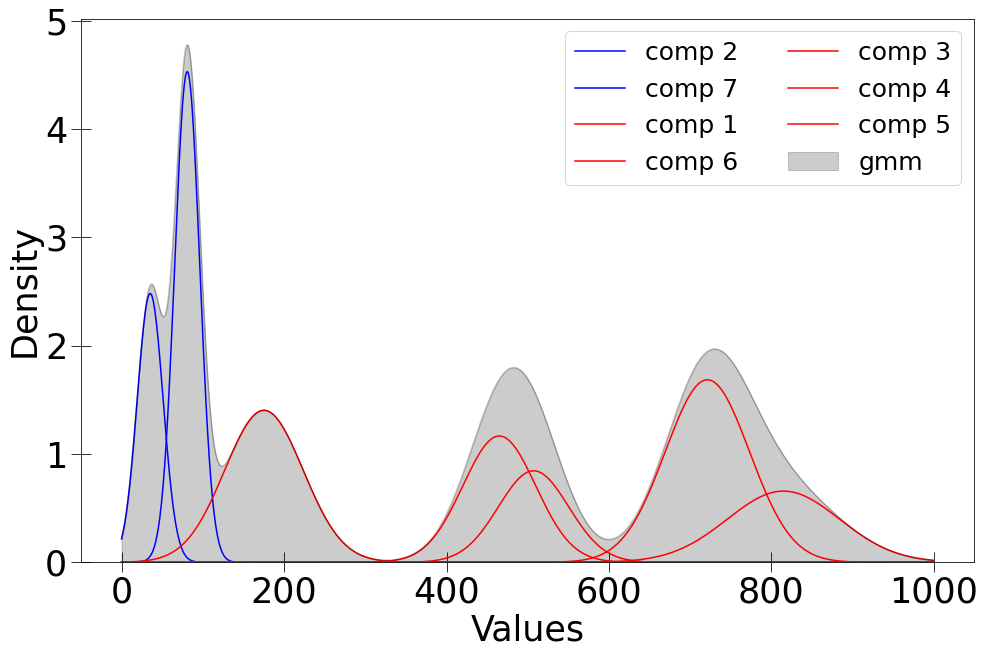

<Figure size 432x288 with 0 Axes>

In [24]:
# Plotting
fontsize=35
figure, axes = plt.subplots(1, 1, figsize=(16, 10))
axes.set_xlabel('Values', fontsize=fontsize)
axes.set_ylabel('Density', fontsize=fontsize)
axes.tick_params(length=20, direction="inout", labelsize=fontsize)

df_pdf_individual[['comp 2', 'comp 7']].plot(ax=axes, color=['blue'], label='Non-discord')
df_pdf_individual[['comp 1', 'comp 6', 'comp 3', 'comp 4', 'comp 5']].plot(ax=axes,
                                                                 color=['r'], 
                                                                 label='Discord')

df_pdf_individual[['gmm']].plot.area(ax=axes,
                                     color=['black'],
                                     alpha=0.2,
                                     legend='GMM')

axes.legend(fontsize=fontsize-10, ncol=2)
plt.show()
plt.tight_layout()
figure.savefig(f'img/gmm-example.png', format='PNG')


# Results

## Classification
Look for classification matrices generated by the following notebooks:

`classification_<model>.ipynb`

Where model is one of the 2 benchmarked models: `aldi`, `aldipp`, `2sd`, `vae`

## Forecasting

{'baseline': {'rmsle': 2.8413786309110587}, '2std': {'rmsle': 2.8350654314815067}, 'aldi_vanilla': {'rmsle': 2.8336576991253355}, 'discord_vae': {'rmsle': 2.828975078264215}, 'discords_aldi_gmm_weight_D-gmm_max_5': {'rmsle': 2.665249075948446}}


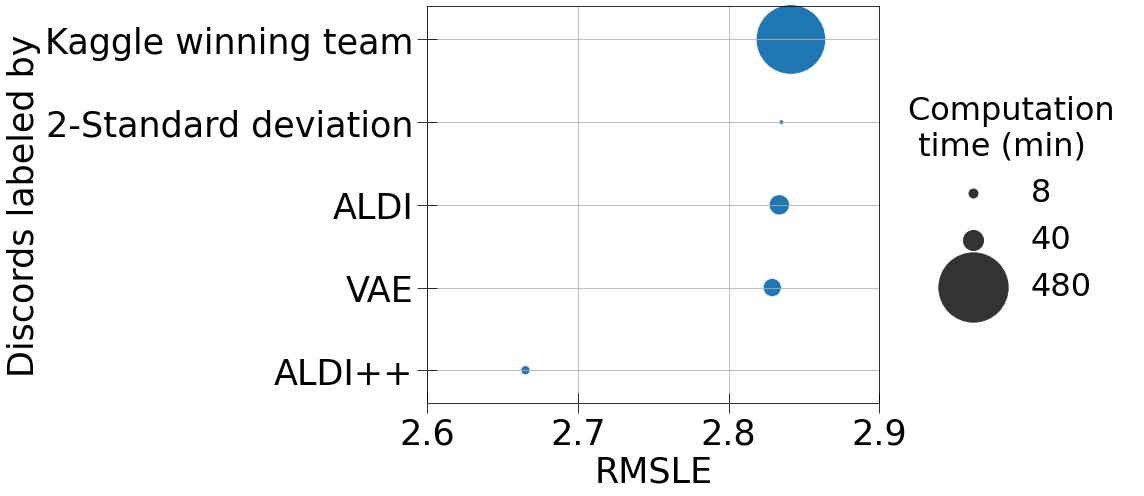

In [3]:
print(dict_algo)

forecasting_bubble(
    merge({}, dict_algo, dict_time),
    plot_name='forecasting_paper',
    y_labels=tick_labels,
    figsize=(16,7),
    xlim=(2.6, 2.9),
    fontsize=35,
)